# Classifying Lumity Clients by Primary Characteristics
In this Jupyter Notebook demo, we examine information from Lumity's main clients obtained in 2019 and classify clients with similarly related plan characteristics. In particular, Lumity has two types of plan characteristics. The primary characteristics are the client's
* Employee Size
* Average Employee Age
* Percentage of Male Employees
* Standard Industrial Classification (SIC)
* Region Headquarters

The secondary characteristics include the client's
* Medical plan carrier
* Employee/family costs
* Rates

The ultimate goal is to obtain optimal benchmark plan(s) which Lumity can recommend to clients. In this Jupyter notebook, we specifically focus on classifying clients by their primary characteristics. We give another Machine Learning approach using the famous unsupervised $k$-Means clustering algorithm iteratively. The notebook will be detailed and accessible to Lumity's Product Management Team and other interested parties.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import os
import pickle

# Preprocessing Data
Recall from the introduction, we wish to classify clients based on their   
* Employee Size
* Average Employee Age
* Percentage of Male Employees
* Standard Industrial Classification
* Region Headquarters

At the time of writing, the 'Demographics.csv' file contains primary characteristic information for $126$ different clients. Each row in the dataframe is a datapoint with an individual client's primary characteristics as its entries. 

Before we apply the clustering algorithms, we will do some preprocessing on the dataframe. First, we eliminate clients with any incomplete/missing primary characteristic data. $\textbf{As of writing, there are $113$ clients that have complete information out of $126$ total clients}.$ Then, we take certain columns and convert their values to integers or floats. Finally, we extract the SIC Code and put it into a separate column. We show the output of the first $5$ rows of the dataframe after preprocessing.

In [4]:
df=pd.read_csv('Demographics.csv')[['Client/Prospect','Size', 'Region (HQ)', 'SIC Code - Industry', 
                         'Average Employee Age','Percentage Male']] 
print("There are {0} total clients.".format(len(df)))
df=df.dropna(axis=0) #Removing clients with missing/incomplete data
df['Size']=df['Size'].apply(lambda x: int(x))
df['Percentage Male']=df['Percentage Male'].apply(lambda x:float(x[:2]))
df['SIC Code']=df['SIC Code - Industry'].apply(lambda x: x.split("-")[0].strip())
df=df.sort_values(by='Size')
numerical_characteristics=['Size', 'Average Employee Age','Percentage Male']
categorical_characteristics=['SIC Code','Region (HQ)']
primary_characteristics=numerical_characteristics+categorical_characteristics

print("There are {0} total clients with complete information.".format(len(df)))
df.head(5)[['Client/Prospect']+primary_characteristics] 

There are 126 total clients.
There are 113 total clients with complete information.


Client/Prospect  Size  Average Employee Age  Percentage Male SIC Code  \
38         Feedzai     5                 41.85             60.0     7372   
96     Rock Health    11                 28.27             36.0     8621   
81        NimbleRx    31                 30.70             55.0     7372   
75          Movoto    34                 36.40             59.0     6531   
66          Legion    37                 40.00             84.0     7374   

     Region (HQ)  
38      Bay Area  
96      Bay Area  
81      Bay Area  
75  Pennsylvania  
66      Bay Area

# k-Means Clustering

We have a set of $d$ datapoints $\mathcal{D}= \lbrace \mathbf{x}_1, \ \dots \ , \mathbf{x}_d \rbrace,$ where each $\mathbf{x}_i$ contains $n$ component values. In Lumity's case, there are $d=113$ datapoints corresponding to $113$ clients available for analysis. Explicitly, each $\mathbf{x}_i$ from $\mathcal{D}$ is a vector of the format $\textbf{x}_i=(x_{i,1}, \ \dots \ , x_{i,n}),$ where $x_{i,j}$ is the value of the $j$-th feature of the $i$-th datapoint. In Lumity's case, $n=5,$ the total number of primary characteristics, and $x_{i,j}$ is the value of the $j$-th primary characteristic for Client $i.$ 

We want to determine $\textbf{clusters (groups)}$ of datapoints such that datapoints in a cluster are similarly related to one another. For example, we should have clients with over $1000$ employees fall into one cluster, while clients with less than $100$ employees fall into another cluster. 

We determine such groups by the $K$-means algorithm. The goal of $K$-means is to determine a collection of $K$ different $n$-dimensional $\textbf{centroid}$ vectors $\mathcal{C}= \lbrace \mathbf{\mu}_1, \ \dots \ , \mathbf{\mu}_K \rbrace.$ Each centroid $\mathbf{\mu}_k$ from $\mathcal{C}$ corresponds to the center of the $k$-th cluster and possesses "average" properties of datapoints in that cluster. For example, a cluster with clients over $1000$ employees must have a centroid such that its component containing the average number of employees has a value bigger than $1000.$

The algorithm declares two datapoints $\mathbf{x}_a$ and $\mathbf{x}_b$ from $\mathcal{D}$ are $\textbf{similar}$ if there is a centroid $\mu_k$ from $\mathcal{C}$ that is closest to both $\mathbf{x}_a$ and $\mathbf{x}_b$ in Euclidean Distance. The $\textbf{Euclidean Distance}$ of the $n$-dimensional vectors $\mathbf{p}=(p_1, \ \dots \ , p_n)$ and $\mathbf{q}=(q_1, \ \dots \ , q_n)$ is defined to be the number
$$\|\mathbf{p}-\mathbf{q}\|=\sqrt{(p_1-q_1)^2 + \ \dots \ + (p_n-q_n)^2}.$$ 


$K$-means is implemented as follows. We fix a value $K,$ which is the number of clusters we wish to partition our dataset $\mathcal{D}$ into. It initializes centroids $\mu_1, \ \ \dots \ , \mu_K$ to be random points in $n$-dimensional space. Then, it iteratively updates these centroids using a specific Expectation Maximation formula to minimize the cost function $$f(\mu_1, \ \dots \ , \mu_K)= \sum_{i=1}^d\sum_{k=1}^K a_{i,k} \|\mathbf{x}_i-\mu_k\|^2,$$ where $$a_{i,k}=\begin{cases} 1 & \mathbf{x}_i \text{ placed into Cluster $k$} \\ 0 & \text{else} \end{cases}.$$ At each iteration, for every datapoint $\mathbf{x}_i$ from $\mathcal{D},$ we seek the center $\mu_k$ from $\mathcal{C}$ that minimizes $\|\mathbf{x}_i-\mu_k\|.$ This means $\mathbf{x}_i$ will be put into Cluster $k.$

# k-Modes Clustering

But the $K$-means algorithm described in the previous section will not directly work on the client dataset. $K$-means assumes all datapoints have only numerical features (for the Euclidean Distance to make sense). Recall from earlier SIC Code and Region Headquarters are categorical features. How do we modify the approach then to account for this situation ? This is where the $K$-Modes algorithm comes into play.  

First, we need to define what it means to take 'distances' of $2$ categorical values. Let $\mathbf{P}=(P_1, \ \dots \ , P_r)$ and $\mathbf{Q}=(Q_1, \ \dots \ , Q_r)$ be $2$ different datapoints possessing categorical values in their entries. We define their $\textbf{Hamming Distance}$ to be the number 
$$\|P-Q\|_H = \delta(P_1,Q_1) + \ \dots \ + \delta(P_r,Q_r),$$ where $$\delta(P_i,Q_i)= \begin{cases} 0 & \text{ if $P_i=Q_i$} 
\\ 1 & \text{ if $P_i \neq Q_i$} \end{cases}.$$ In Layman's terms, the Hamming Distance counts the number of dissimilar component values between $P$ and $Q.$ The smaller this number is, the 'closer' $P$ and $Q$ are. 

For example, say Client $A$ is based in the Bay Area and has SIC Code $7371$ (i.e. $A$ is a computer programming service) and client $B$ is based in New York but also has the same SIC code $7371.$ The hamming distance between these categorical features of $A$ and those of $B$ is equal to $0+1=1,$ since both clients are based in different locations but are of the same industry type. 

Analagous to the goal of $K$-means, the goal of $K$-modes is to determine a collection of $K$ different $r$-dimensional $\textbf{mode}$ vectors $\mathcal{M}= \lbrace \mathbf{m}_1, \ \dots \ , \mathbf{m}_K \rbrace.$ Each centroid $\mathbf{m}_k$ from $\mathcal{M}$ corresponds to the center of the $k$-th cluster of categorical datapoints, but possesses 'modal' properties of datapoints in that cluster.  For example, a cluster with clients with a majority of clients located in the Bay Area must have a mode vector such that the component containing the regional headquarters should be Bay Area. 

$K$-modes is implemented as follows. We fix a value $K,$ which is the number of clusters we wish to partition our categorical dataset $\mathcal{E}=\lbrace \textbf{P}_1, \ \dots \ , \textbf{P}_s \rbrace$ into, where $\mathbf{P}_i=(P_{i,1},  \ \dots \ , P_{i,r}).$ It initializes modes $\mathbf{m}_1, \ \ \dots \ , \mathbf{m}_K$ to be random points in $r$-dimensional space. Then, it iteratively updates these modes using a specific Expectation Maximation formula to minimize the cost function $$g(\mathbf{m}_1, \ \dots \ , \mathbf{m}_K)= \sum_{i=1}^d\sum_{k=1}^K b_{i,k} \| \mathbf{P}_i- \mathbf{m}_k \|_H,$$ where $$b_{i,k}=\begin{cases} 1 & \mathbf{x}_i \text{ placed into Cluster $k$} \\ 0 & \text{else} \end{cases}.$$ At each iteration, for every datapoint $\mathbf{P}_i$ from $\mathcal{E},$ we seek the mode $\mathbf{m}_k$ from $\mathcal{M}$ that minimizes $\|\mathbf{P}_i-\mathbf{m}_k\|.$ This means $\mathbf{P}_i$ will be put into Cluster $k.$

# Iterative k-means and modes

We will use $K$-means iteratively. That is, we will first take the employee size and form clusters using $K$-means. On each of such size clusters, we will cluster by the average employee age. On each of those clusters, we will cluster by the percentage of males. We finally cluster all these clusters by SIC Code and Region Headquarters $K$-Modes.   

The question remains how to choose $K$ suitably at each level of clustering ? In practice, we use what is known as the $\textbf{elbow method}.$ For small values of $K,$ i.e. $K$ in between $1$ and $10,$ we run the $K$-prototypes algorithm to obtain the centers, and we plot the resulting inertia $f.$ As $K$ increases, $f$ decreases but stagnates after a certain $K$ value. In Layman's terms, after a certain $K$ value, there is a 'law of diminishing returns' choosing a higher number of clusters. We show give a plot of the elbow method below. 

In [11]:
def cluster_by_feature(feature,X=df,n_clusters=7):
    if(n_clusters>=len(X)):
        X['{0}_Cluster'.format(feature)]=X[feature].apply(lambda x: "{0} - {1}".format(X[feature].min(),
                                                                         X[feature].max()))
        return X
    X=X.sort_values(by=feature)
    feature_km=KMeans(n_clusters,n_init=100)
    feature_km.fit_transform(np.array(X[feature]).reshape(-1,1))
    X['{0}_Cluster'.format(feature)]=feature_km.labels_
    unique_labels=list(X['{0}_Cluster'.format(feature)].unique()) # K-means randomizes the order of labels on every trial.
    modified_labels=range(n_clusters)
    relabel_dict=dict(zip(unique_labels, modified_labels))
                      # For consistency, we use a dictionary to relabel everything in INCREASING ORDER. 
    X['{0}_Cluster'.format(feature)]=X['{0}_Cluster'.format(feature)].apply(lambda x: relabel_dict[x])
    clusters=[X[X['{0}_Cluster'.format(feature)]==k] for k in range(n_clusters)]
    X['{0}_Cluster'.format(feature)]=X['{0}_Cluster'.format(feature)].apply(lambda x: "{0} - {1}".format(clusters[x][feature].min(),
                                                                         clusters[x][feature].max()))
    return X

def inertia_plot(feature,X=df):
    stop=min(len(X),10)
    inertias=[]
    for n_clusters in range(1,stop):
        feature_km=KMeans(n_clusters,n_init=100)
        feature_km.fit_transform(np.array(X[feature]).reshape(-1,1))
        inertias.append(feature_km.inertia_)
    fig, ax = plt.subplots()
    ax.plot(range(1,len(inertias)+1),inertias)
    ax.set_title("Elbow Method by Inertia of {0}".format(feature))
    ax.scatter(range(1,len(inertias)+1),inertias,marker='x',color='red')
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Inertia")
    return ax

def get_feature_clusters(feature,X=df,n_clusters=7):
    X=cluster_by_feature(feature=feature,X=X,n_clusters=n_clusters)
    cluster_labels=X['{0}_Cluster'.format(feature)].unique()
    return [X[X['{0}_Cluster'.format(feature)]==label] 
            for label in cluster_labels]


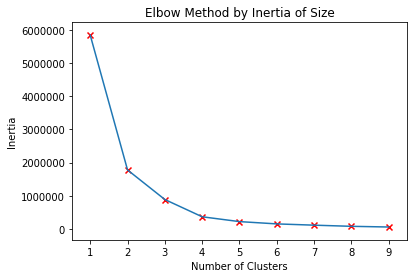

In [12]:
inertia_plot("Size")

In [13]:
size_clusters=get_feature_clusters("Size",n_clusters=4)
[len(cluster) for cluster in size_clusters]

[73, 27, 10, 3]

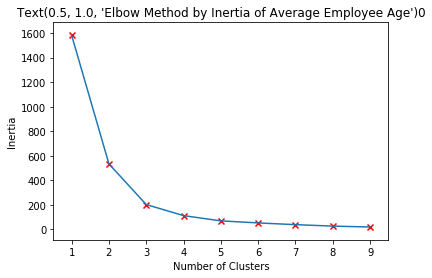

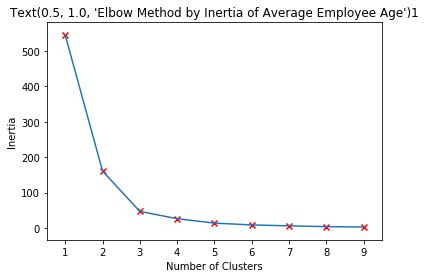

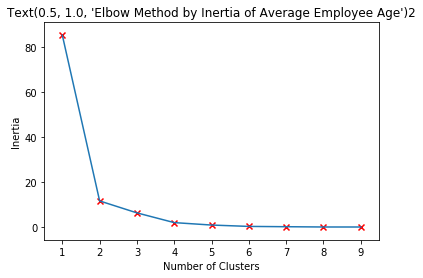

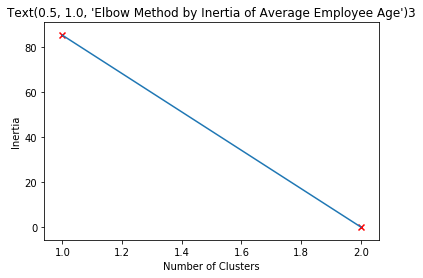

In [25]:
axes=[inertia_plot("Average Employee Age", size_cluster) for size_cluster in size_clusters]

In [18]:
employee_clusters=[cluster  for size_cluster in size_clusters 
                   for cluster in get_feature_clusters("Average Employee Age",size_cluster,4)]
[len(employee_cluster) for employee_cluster in employee_clusters]

[27, 26, 13, 7, 12, 4, 7, 4, 2, 1, 2, 5, 3]

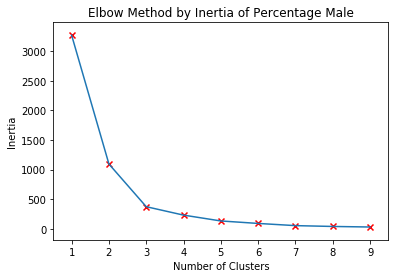

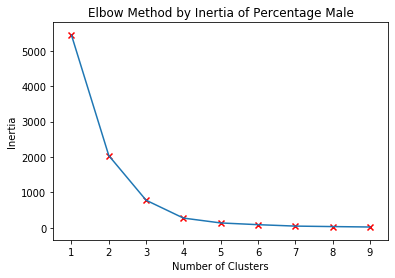

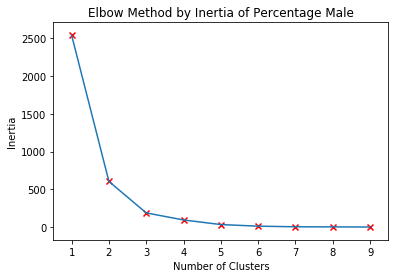

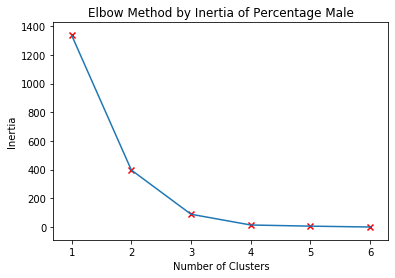

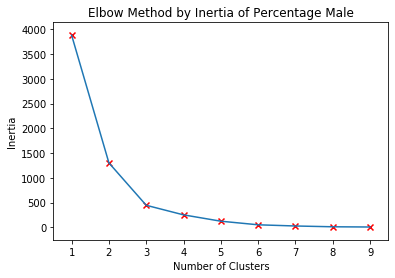

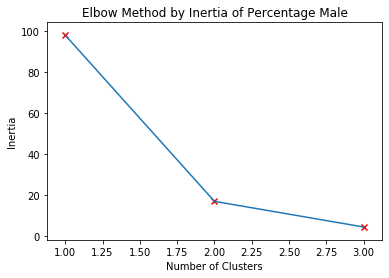

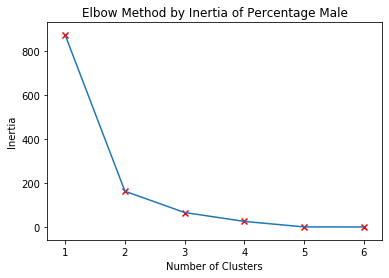

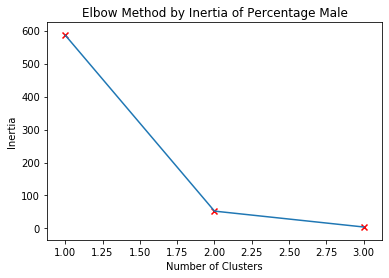

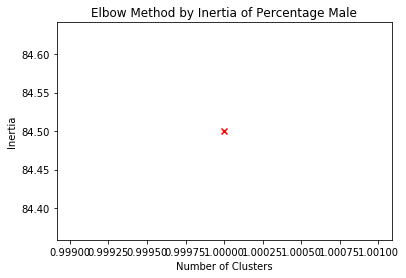

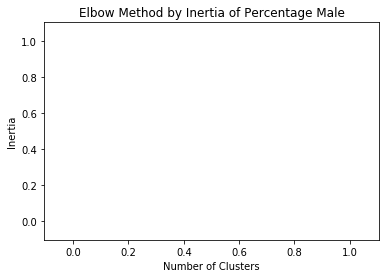

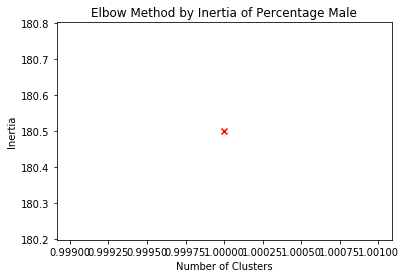

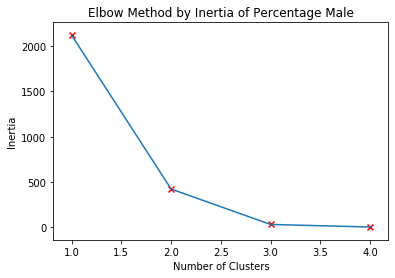

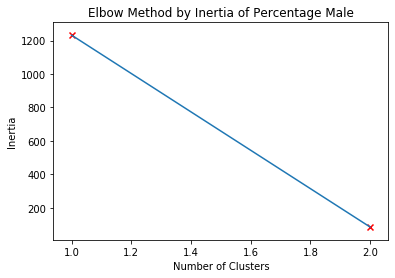

In [19]:
[inertia_plot("Percentage Male", employee_cluster) for employee_cluster in employee_clusters]

In [ ]:
male_clusters=[cluster for employee_cluster in employee_clusters 
                   for cluster in get_feature_clusters("Percentage Male",employee_cluster,3)] #Cluster all employee age clusters by percentage male

[len(male_cluster) for male_cluster in male_clusters]

In [ ]:
def cluster_by_industry(X=df,n_clusters=3):
    X['SIC Code']=X['SIC Code - Industry'].apply(lambda x: x.split("-")[0].strip())
    km = KModes(n_clusters=n_clusters, init='Huang',n_init=100)
    #km.fit_predict(np.chararray(X['SIC Code']).reshape(-1,1))
    X['SIC Code_Cluster']=X['SIC Code'].mode()[0]
    return X

def cluster_by_region(X=df,n_clusters=3):
    X['Region_Cluster']=X['Region (HQ)'].mode()[0]
    return X

final_clusters=[cluster_by_region(cluster_by_industry(cluster,3)) 
                                for cluster in percentage_male_clusters]

In [ ]:
cluster_centroids=[{"Avg. Size": cluster['Size'].mean(),
                    "Avg. Employee Age": cluster['Average Employee Age'].mean(),
                    "Avg. Percentage Male": cluster['Percentage Male'].mean(),
                    "Avg. Industry Type": list(cluster['SIC Code_Cluster'])[0],
                    "Avg. Location": list(cluster['Region_Cluster'])[0]}
                   for cluster in final_clusters]

In [ ]:
def hamming_distance(A,B): #A and B must both be lists of n strings.
    return sum([0  if A[i]==B[i] else 1 for i in range(len(A)) ])

def squared_euclidean_distance(p,q): #p and q must be numpy arrays of float type
    return np.linalg.norm(p-q)**2

def predict_cluster_label(client_info_dict): 
    size=client_info_dict['Size']
    employee_age=client_info_dict['Employee Age']
    percentage_male=client_info_dict['Percentage Male']
    SIC_Code=client_info_dict['SIC Code']
    region=client_info_dict['Region (HQ)']
    
    numerical_features=np.array([size,employee_age,percentage_male])
    categorical_features=[SIC_Code, region]
    
    distances=[squared_euclidean_distance(numerical_features, np.array([centroid['Avg. Size'], 
                                                                        centroid["Avg. Employee Age"],
                                                                        centroid["Avg. Percentage Male"]]))
     + hamming_distance(categorical_features,[centroid["Avg. Industry Type"], 
                                              centroid["Avg. Location"]])
                                for centroid in cluster_centroids]
    minimum_distance_cluster=[i for i in range(len(distances)) if distances[i]==min(distances)][-1]
    return minimum_distance_cluster

In [ ]:
predict_cluster_label({"Size":1400, 
               "Employee Age":54, 
               "Percentage Male": 0.25, 
               "SIC Code": "7379", 
               "Region (HQ)": "Bay Area"})